Objetivo específico: Determinar parâmetros gerais (n° de animais nascidos, período para nascimento e sexagem) da criação animal no biotério do ICC, total e por linhagem, nos últimos 5 anos; 

In [151]:
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

import seaborn as sns

# plt.rcParams.update({'font.size': 20})
# plt.rcParams['xtick.labelsize'] = 20
# plt.rcParams['ytick.labelsize'] = 20


Pergunta: Dados dos requisitantes, tipos de uso - associação com linhagens e demanda e tipos de ensaios. 
Necessário ter todas essas linhagens? -  Alessandra Aguiar.

Tipo de uso: Não temos informações sobre os Usuários Externos para qual tipo de uso, é realizada apenas a produção dos animais. Já os usuários internos da pra saber, porém, não pelo software BioterC

Quais são os pedidos externos e linhagens?
Qual tipo de uso para cada linhagem?
Qual período de pedidos para cada linhagem?

Quais são os pedidos internos e as linhagens?
Qual tipo de uso para cada linhagem?
Qual período de pedidos para linhagem?

In [152]:
#lendo tabela referente a pedidos
ped = pd.read_csv('../../tabelas_test/pedido_2019-06-18.csv', index_col='id')
ped.head()

,solic,mail,lab,exter,ling,num_ani,time,total_time,doses,cep,cep_num_ani,id_orig,caix_est,id_fim,caix_exp,data_inicio,data_solic,data_forn,data_fim
id,,,,,,,,,,,,,,,,,,,
2,Tania,tschepainski@gmail.com,Usuário Externo,x,Balb/c,2,dia,3,2,83050140,666,666,AAA,666,AAA,1421625600,1411391851,666,1411392413
6,Hálisson Tesseroli Miot,halissontm@gmail.com,LPEP,-,Swiss,4,mes,2,5,0000000000,666,16,1-3-2-16,106,4-1-1-106,1412121600,1411583300,1412619416,1418727743
4,Tania,tschepainski@gmail.com,Usuário Externo,.,Balb/c,2,dia,2,2,81300,666,666,AAA,666,AAA,1420070400,1411491911,666,1411491957
5,Claudemir de Souza,claudemir.s@tecpar.br,VIROMOL,-,Swiss,11,dia,30,5,555555,666,14,1-2-7-14,113,NaN,1412899200,1411579273,1412620096,1422037389
7,Camila Oliveira,halissontm@gmail.com,LPEP,-,Balb/c,6,mes,2,5,0000000000,666,50,2-3-1-50,108,4-1-3-108,1412121600,1411583355,1412082161,1418727745


In [153]:
#Numero total de pedidos de usuários externos
ped[ped['lab'] == 'Usuário Externo']['num_ani'].sum()

4168

In [154]:
#Numero total de pedidos internos
ped[ped['lab'] != 'Usuário Externo']['num_ani'].sum()

1608

Mesmo não havendo muitos pedidos pro grupo de Swiss, é a segunda linhagem mais pedida em comparação as outras, seguida do Balb/c.

In [155]:
#pedido de todos os labs externos e internos
ped['ling'].value_counts()

Balb/c       215
Swiss         82
C57BL/6       37
S129KO        21
C57BL06WT     15
Swiss-2        9
S129WT         6
Swiss-1        3
C3H            2
AG129          2
DBA/1J         1
Name: ling, dtype: int64

In [156]:
soma_todos = ped.groupby('ling')
soma_lings = soma_todos.sum()
soma_lings

,num_ani,total_time,doses,cep_num_ani,id_orig,id_fim,data_inicio,data_solic,data_forn,data_fim
ling,,,,,,,,,,
AG129,34,42,2,228,1332,1332,3073183200,3072654732,1332,3076982883
Balb/c,2368,2281,772,111102,132739456122,93973738465,320543108767,320728904351,258132858896,299677883430
C3H,14,31,2,1332,4294967294,4294967294,2995765200,2995507986,2995938565,2995938565
C57BL/6,1310,577,69,23474,62277029816,55846189976,56908162800,56728274438,49045750862,56763934276
C57BL06WT,535,232,13,9990,19327354483,19327354459,21807982800,21788893554,20357519393,21813660180
DBA/1J,10,1,1,490,1950101194,11010112,1556766000,1556809204,1556809299,1558552428
S129KO,287,62,13,11281,22680575229,12120249147,31177602000,31172811116,31190229719,31203070063
S129WT,88,23,2,3996,6442451258,6442451230,8737362000,8737017456,8740465714,8740465714
Swiss,933,852,218,58003,64202025883,55368104630,121226025600,121188286723,104867027109,121505411645


COMEÇA AQUI

In [157]:
#Criando uma variável para receber o filtro só de usuários externos
pedidos_ext = ped[(ped['lab'] == 'Usuário Externo') & 
                  (ped['num_ani'] < 200) & 
                  (ped['exter'] != 'Teste') &
                  (ped['exter'] != 'Teste BioterC')] 

#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#Transformando todas as datas

datas = ['data_inicio', 'data_solic', 'data_forn', 'data_fim']

for d in datas:
    pedidos_ext[d] = pd.to_datetime(pedidos_ext[d], unit = 's') #indica o formato das datas
    
pedidos_ext.head()
#pedidos_ext[pedidos_ext['ling'] == 'C3H']

/home/eloiza/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,solic,mail,lab,exter,ling,num_ani,time,total_time,doses,cep,cep_num_ani,id_orig,caix_est,id_fim,caix_exp,data_inicio,data_solic,data_forn,data_fim
id,,,,,,,,,,,,,,,,,,,
2,Tania,tschepainski@gmail.com,Usuário Externo,x,Balb/c,2,dia,3,2,83050140,666,666,AAA,666,AAA,2015-01-19,2014-09-22 13:17:31,1970-01-01 00:11:06,2014-09-22 13:26:53
4,Tania,tschepainski@gmail.com,Usuário Externo,.,Balb/c,2,dia,2,2,81300,666,666,AAA,666,AAA,2015-01-01,2014-09-23 17:05:11,1970-01-01 00:11:06,2014-09-23 17:05:57
9,Phileno,tschepainski@gmail.com,Usuário Externo,UEL,Swiss,25,mes,2,3,3433,666,20,1-3-6-20,1,1-1-1-1,2014-10-07,2014-09-29 13:33:14,2014-10-01 17:33:31,2014-10-01 17:33:31
10,Phileno,tschepainski@gmail.com,Usuário Externo,UEL,Balb/c,120,dia,40,12,00000,666,54,2-3-5-54,1,1-1-1-1,2014-12-01,2014-09-29 19:27:01,2014-10-01 17:51:45,2014-10-01 17:51:45
12,Phileno,tschepainski@gmail.com,Usuário Externo,UEL,C57BL06WT,120,dia,12,2,000000,666,96,3-4-5-96,1,1-1-1-1,2014-10-08,2014-10-01 18:14:28,2014-10-01 18:37:50,2014-10-01 18:37:50


In [158]:
# #verificando pedidos externos para relatório do Giovanny
# pedidos_ext[(pedidos_ext['mail'] == 'bordignonjuliano@gmail.com') & (pedidos_ext['ling']=='S129KO')]['num_ani'].sum()
                                                             


In [159]:
#Verificando a soma dos animais dessa linhagem:
#ped[ped['ling'] == 'C57BL06WT']['num_ani'].sum()

In [160]:
#Verificando a soma dos animais dessa linhagem:
#ped[ped['ling'] == 'C57BL/6']['num_ani'].sum()

In [161]:
#Substituindo linhagem 'C57BL06WT' por 'C57BL/6' - "concatenando as linhagens"
pedidos_ext['ling'].replace('C57BL06WT', 'C57BL/6', inplace=True)
pedidos_ext['ling'].value_counts()

/home/eloiza/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Balb/c     78
C57BL/6    49
Swiss      32
S129KO     14
S129WT      6
C3H         2
Name: ling, dtype: int64

In [162]:
#Após "concatenação" foi somado o valor da linhagem C57BL/6 (porem, não esta dando o valor correto da soma) 
pedidos_ext[pedidos_ext['ling'] == 'C57BL/6']['num_ani'].sum()

1820

In [163]:
#Substituindo linhagem 'Swiss-1', 'Swiss-2' por 'Swiss' - "concatenando as linhagens"
pedidos_ext['ling'].replace(['Swiss-1', 'Swiss-2'],'Swiss' ,inplace=True)
pedidos_ext['ling'].value_counts()

Balb/c     78
C57BL/6    49
Swiss      32
S129KO     14
S129WT      6
C3H         2
Name: ling, dtype: int64

In [164]:
#Ao somar a linhagem Swiss era para retornar um valor maior
pedidos_ext[pedidos_ext['ling'] == 'Swiss']['num_ani'].sum()

682

In [165]:
g = pedidos_ext.groupby('ling')
g.sum()

,num_ani,total_time,doses,cep_num_ani,id_orig,id_fim
ling,,,,,,
Balb/c,1392,906,160,51948,64190850032,60467856096
C3H,14,31,2,1332,4294967294,4294967294
C57BL/6,1820,780,65,31892,79456899726,75173543075
S129KO,85,36,6,9324,11942755795,9922754927
S129WT,88,23,2,3996,6442451258,6442451230
Swiss,682,374,42,21312,45003787282,36689966697


In [166]:
pedidos_ext['exter'].value_counts()[:25]

UFPR                                                  40
UEL                                                   12
UFPR - Departamento de Fisiologia                     12
Laboratorio de Virologia Molecular - ICC - Fiocruz     8
Universidade Federal do Paraná                         8
Viromol                                                7
Pontifícia Universidade Católica do Paraná             5
Universidade Estadual de Londrina-UEL                  5
UFSC                                                   5
Universidade Federal do Rio de Janeiro                 5
UNIVALI                                                4
Universidade Estadual de Londrina                      4
Viromol ICC                                            4
Universidade Federal de Santa Catarina                 3
Biotério                                               3
IBMP                                                   3
ViroMol                                                3
ICC                            

In [170]:
pedidos_ext['exter'].replace(('Universidade Federal do Paraná','UNiversidade Federal do Parana', 'Ufpr', 'ufpr','UfPR',
                             'UFPR - Biologia Celular', 'UFPR - Departamento de Fisiologia', 'UFPR - LABMICRO','UFPR - Centro Politécnico'), 'UFPR', inplace=True)
# pedidos_ext['exter'].value_counts()
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
pedidos_ext['exter'].replace(('Universidade Estadual de Londrina-UEL','Universidade Estadual de Londrina'), 'UEL', inplace=True)
# pedidos_ext['exter'].value_counts()
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
pedidos_ext['exter'].replace(('Viromol','ViroMol','Vriromol','Lab viromol', 'Virologia', 'Virologia Molecular Fiocruz',
                             'Laboratorio de Virologia Molecular - ICC - Fiocruz', 'Virologia '), 'Viromol ICC', inplace=True)
# pedidos_ext['exter'].value_counts()
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
pedidos_ext['exter'].replace((' Universidade da Fronteira sul','Universidade da Fronteira sul',
                              'UNiversidade Federal da Fronteira Sul'), 'Universidade Federal da Fronteira Sul', inplace=True)
#pedidos_ext['exter'].value_counts()
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
pedidos_ext['exter'].replace('Univali', 'UNIVALI', inplace=True)
# pedidos_ext['exter'].value_counts()
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
pedidos_ext['exter'].replace('Universidade Federal de Santa Catarina', 'UFSC', inplace=True)
# pedidos_ext['exter'].value_counts()
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
pedidos_ext['exter'].replace('Universidade Federal do Rio de Janeiro', 'UFRJ', inplace=True)
# pedidos_ext['exter'].value_counts()
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
pedidos_ext['exter'].replace('Instituto de Biologia Molecular do Paraná', 'IBMP', inplace=True)
# pedidos_ext['exter'].value_counts()
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
pedidos_ext['exter'].replace(('Instituto Carlos Chagas','ICC - teste', 'LabGen', 'LPEP', 'LABCET', 'Labreg', 'REG', 'Genomica',
                             'Lab Reg', 'GEN', 'BiomolTrip', 'Viromol ICC'), 'ICC', inplace=True)
# pedidos_ext['exter'].value_counts()
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
pedidos_ext['exter'].replace('Universidade Federal de Santa Maria - UFSM', 'UFSM', inplace=True)
# pedidos_ext['exter'].value_counts()
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
pedidos_ext['exter'].replace(('biotério','BIOT TESTE'), 'Biotério', inplace=True)
# pedidos_ext['exter'].value_counts()
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
pedidos_ext['exter'].replace(('Test exter','externo','x','.','Lab Test','wded','Externo'), 'EXTERNO', inplace=True)
pedidos_ext['exter'].value_counts()

/home/eloiza/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


UFPR                                            68
ICC                                             40
UEL                                             21
UFSC                                             8
EXTERNO                                          8
UFRJ                                             6
UNIVALI                                          5
Biotério                                         5
Pontifícia Universidade Católica do Paraná       5
IBMP                                             4
Universidade Federal da Fronteira Sul            4
Universidade de São Paulo                        2
UFSM                                             2
Fiocruz Bahia                                    1
FIOCRUZ - Centro de Pesquisa Aggeu Magalhães     1
Immunova                                         1
Institute Nagib Lab                              1
BIOVET                                           1
Universidade Estadual do Oeste do Paraná         1
Name: exter, dtype: int64

Text(0, 0.5, 'Laboratórios')

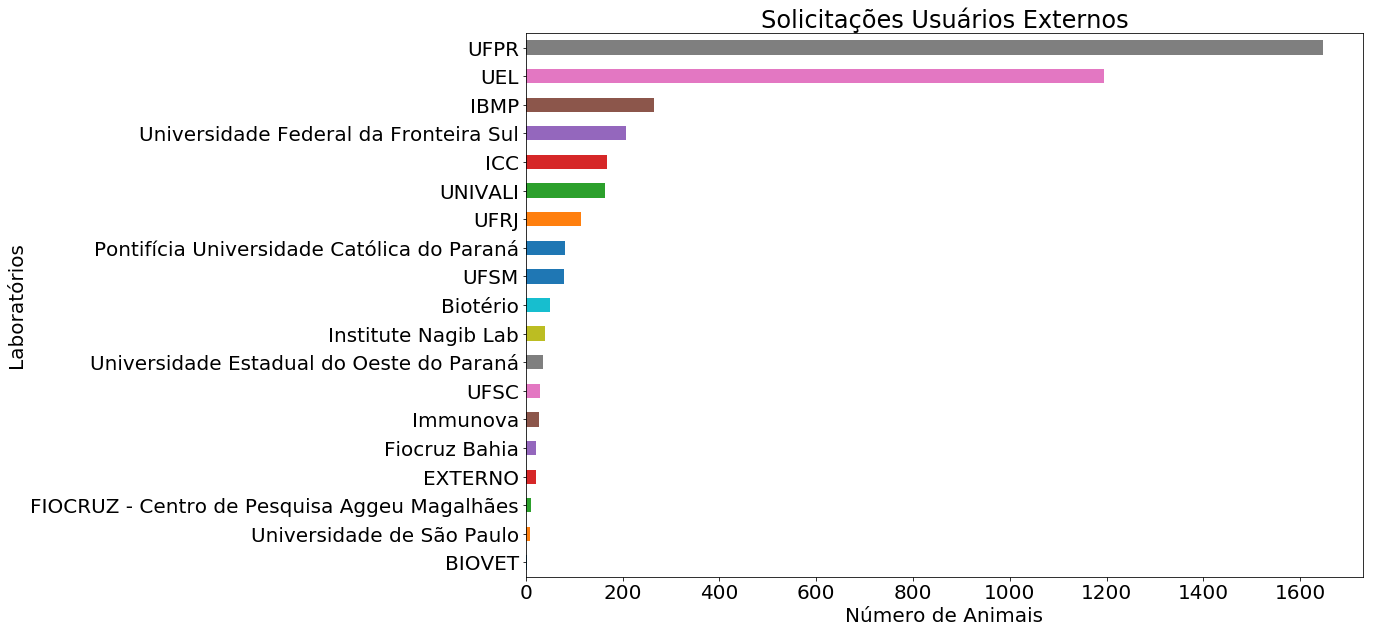

In [171]:
plt.figure(figsize=(15,10))
plt.title('Solicitações Usuários Externos')

plot = pedidos_ext.groupby('exter')
plot['num_ani'].sum().sort_values(ascending=True).plot(
kind='barh'
)
plt.xlabel('Número de Animais') #definindo nome do eixo X
plt.ylabel('Laboratórios') #definindo nome do eixo Y

In [172]:
testando = pedidos_ext.groupby('exter')
testando.sum()

,num_ani,total_time,doses,cep_num_ani,id_orig,id_fim
exter,,,,,,
BIOVET,3,3,5,666,45,110
Biotério,50,47,8,3330,4338978189,6442451713
EXTERNO,20,53,13,5328,2147487097,2147487651
FIOCRUZ - Centro de Pesquisa Aggeu Magalhães,10,1,1,666,2147483647,2147483647
Fiocruz Bahia,20,1,1,666,2147483647,2147483647
IBMP,264,51,3,1922,4294967803,4294967561
ICC,167,599,66,26640,29268658646,24156518663
Immunova,27,1,1,666,2147483647,2147483647
Institute Nagib Lab,40,41,2,666,477,478


In [37]:
# plt.figure(figsize=(15,10))
# plt.title('Mediana do período de acasalamento ao nascimento por linhagem')

# plot = pedidos_ext.groupby('exter')
# plot['num_ani'].sum().sort_values(ascending=True).plot(
# kind='barh'
# )

In [16]:
ling_mais_soli_ano = ['Balb/c','C57BL/6','Swiss']

g_ling_mais_ped_ex = pedidos_ext[pedidos_ext['ling'].isin(ling_mais_soli_ano)].groupby('ling')
lin_mais_ped_ex = g_ling_mais_ped_ex.sum()
lin_mais_ped_ex

,num_ani,total_time,doses,cep_num_ani,id_orig,id_fim
ling,,,,,,
Balb/c,1399,913,167,56610,66150954845,62397960910
C57BL/6,1820,780,65,31892,79456899726,75173543075
Swiss,682,374,42,21312,45003787282,36689966697


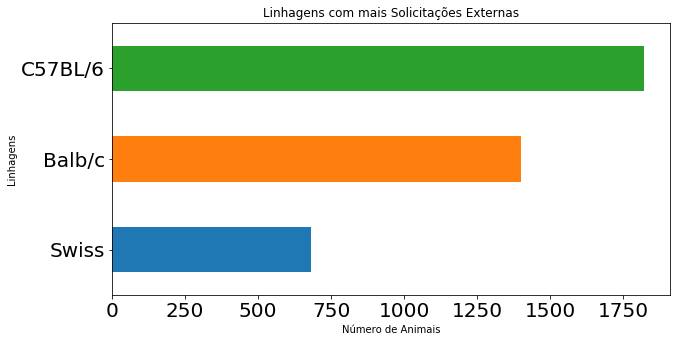

In [17]:
plt.figure(figsize=(10,5))
plt.title('Linhagens com mais Solicitações Externas')

plot = lin_mais_ped_ex.groupby('ling')
plot['num_ani'].sum().sort_values(ascending=True).plot(
kind='barh'

)
plt.xlabel('Número de Animais') #definindo nome do eixo X
plt.ylabel('Linhagens') #definindo nome do eixo Y
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#Salvando os gráficos
plt.savefig(
    fname="../../resultados/animais_mais_ext_I.png", #pasta e nome do arquivo onde vai ser salvo
    bbox_inches='tight', #função que deixa o gráfico mais próxima da margem
    dpi=150, #numero de pixels da imagem?
    transparent=True #deixar o gráfico transparente
)

In [18]:
ling_menos_soli_ano = ['S129KO', 'S129WT', 'C3H' ]

g_ling_menos_ped_ex = pedidos_ext[pedidos_ext['ling'].isin(ling_menos_soli_ano)].groupby('ling')
lin_menos_ped_ex = g_ling_menos_ped_ex.sum()
lin_menos_ped_ex

,num_ani,total_time,doses,cep_num_ani,id_orig,id_fim
ling,,,,,,
C3H,14,31,2,1332,4294967294,4294967294
S129KO,85,36,6,9324,11942755795,9922754927
S129WT,88,23,2,3996,6442451258,6442451230


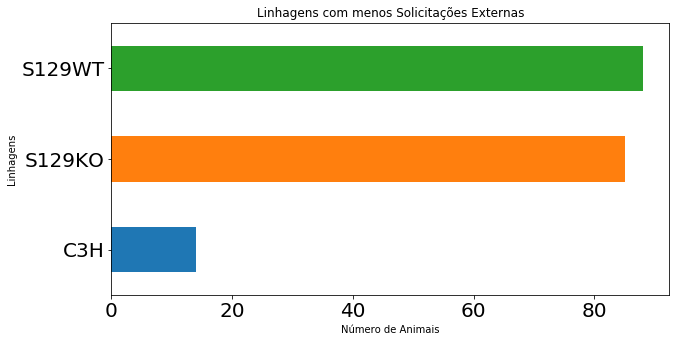

In [19]:
plt.figure(figsize=(10,5))
plt.title('Linhagens com menos Solicitações Externas')

plot = lin_menos_ped_ex.groupby('ling')
plot['num_ani'].sum().sort_values(ascending=True).plot(
kind='barh'

)
plt.xlabel('Número de Animais') #definindo nome do eixo X
plt.ylabel('Linhagens') #definindo nome do eixo Y
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#Salvando os gráficos
plt.savefig(
    fname="../../resultados/animais_menos_ext_I.png", #pasta e nome do arquivo onde vai ser salvo
    bbox_inches='tight', #função que deixa o gráfico mais próxima da margem
    dpi=150, #numero de pixels da imagem?
    transparent=True #deixar o gráfico transparente
)

SÉRIES TEMPORAIS + MODELO PREDITIVO PARA PEDIDOS EXTERNOS 

In [20]:
#Determinar o período de data de pedido e data de fornecimento
pedido_df = pd.DataFrame(pedidos_ext['data_solic'])
pedido_df['ling'] = pedidos_ext['ling']
pedido_df['lab'] = pedidos_ext['lab']
pedido_df['num_ani'] = pedidos_ext['num_ani']
pedido_df['data_forn'] = pedidos_ext['data_forn']
pedido_df = pedido_df.set_index('data_solic')
pedido_df.head()

,ling,lab,num_ani,data_forn
data_solic,,,,
2014-09-22 13:17:31,Balb/c,Usuário Externo,2,1970-01-01 00:11:06
2014-09-23 17:05:11,Balb/c,Usuário Externo,2,1970-01-01 00:11:06
2014-09-29 13:33:14,Swiss,Usuário Externo,25,2014-10-01 17:33:31
2014-09-29 19:27:01,Balb/c,Usuário Externo,120,2014-10-01 17:51:45
2014-10-01 18:14:28,C57BL/6,Usuário Externo,120,2014-10-01 18:37:50


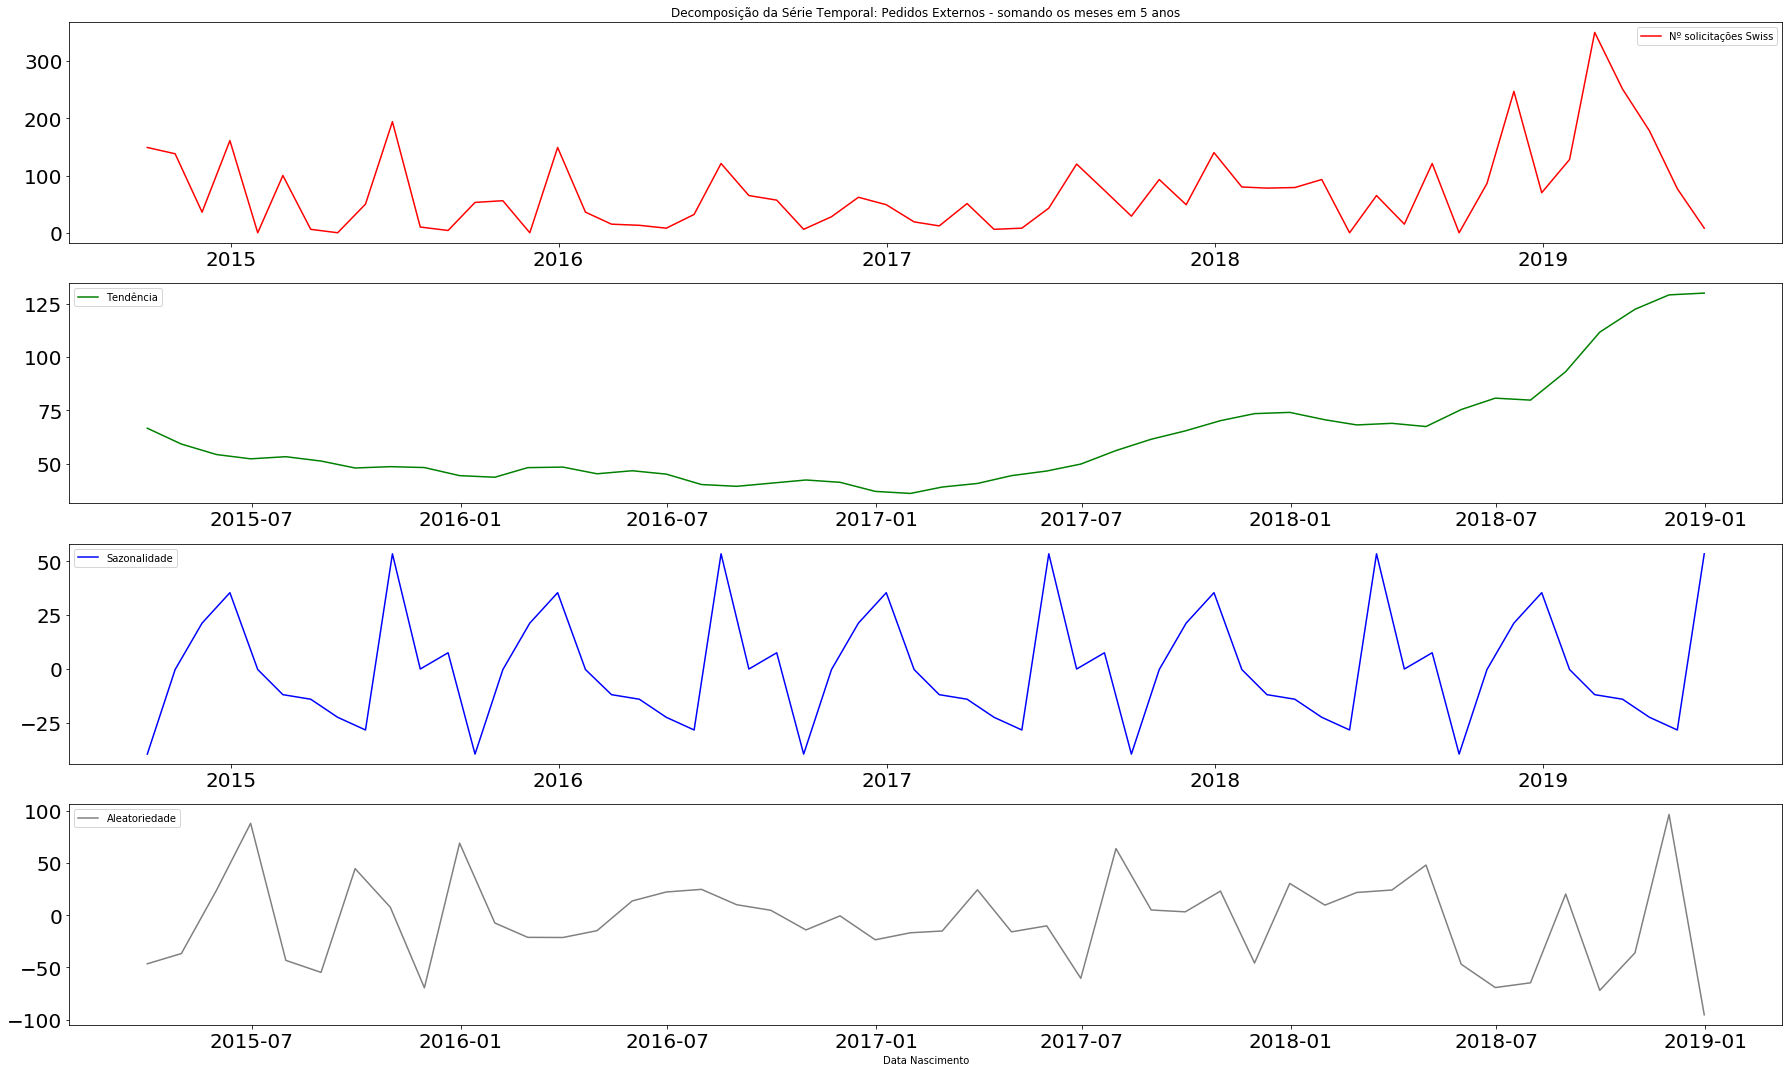

In [21]:
#Gráfico de série temporal por linhagem somando os meses 
serie_ling = pedido_df.resample('M').sum() #pedidos externos somando os meses
decom = seasonal_decompose(serie_ling, freq=12)

# Plotagem de gráfico ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
plt.figure(figsize=(25, 15))
plt.title('Decomposição da Série Temporal Nascimento de Animais') 
plt.legend(['Decomposição da Série Temporal Nascimento de Animais'])

plt.subplot(4, 1, 1)
plt.plot(serie_ling, label = 'Nº solicitações Swiss', color='red')
plt.legend(loc = 'best')
plt.title('Decomposição da Série Temporal: Pedidos Externos - somando os meses em 5 anos') 

plt.subplot(4, 1, 2)
plt.plot(decom.trend, label = 'Tendência', color='green')
plt.legend(loc = 'best')

plt.subplot(4, 1, 3)
plt.plot(decom.seasonal, label = 'Sazonalidade', color='blue')
plt.legend(loc = 'best')

plt.subplot(4, 1, 4)
plt.plot(decom.resid, label = 'Aleatoriedade', color='grey')
plt.legend(loc = 'best')

plt.xlabel('Data Nascimento')
plt.tight_layout()


In [59]:
# #Gráfico de série temporal por linhagem somando os meses 
# serie_ling = pedido_df.resample('W').sum()
# decom = seasonal_decompose(serie_ling, freq=12)

# # Plotagem de gráfico ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# plt.figure(figsize=(25, 15))
# plt.title('Decomposição da Série Temporal Nascimento de Animais') 
# plt.legend(['Decomposição da Série Temporal Nascimento de Animais'])

# plt.subplot(4, 1, 1)
# plt.plot(serie_ling, label = 'Nº solicitações Swiss', color='red')
# plt.legend(loc = 'best')
# plt.title('Decomposição da Série Temporal: Pedidos Externos - somando as semanas em 5 anos') 

# plt.subplot(4, 1, 2)
# plt.plot(decom.trend, label = 'Tendência', color='green')
# plt.legend(loc = 'best')

# plt.subplot(4, 1, 3)
# plt.plot(decom.seasonal, label = 'Sazonalidade', color='blue')
# plt.legend(loc = 'best')

# plt.subplot(4, 1, 4)
# plt.plot(decom.resid, label = 'Aleatoriedade', color='grey')
# plt.legend(loc = 'best')

# plt.xlabel('Data Nascimento')
# plt.tight_layout()


In [60]:
# from statsmodels.tsa.arima_model import ARIMA

In [61]:
# previsao = pedido_df.resample('M').sum()               #somando mês a mês
# previsao = previsao['num_ani']                                     #para trabalhar com a previsão deve usar uma série, na qual foi escolhida 'num_ani'
# previsao.head()

In [62]:
# pedido_df.index.max()

In [63]:
# for p in range(3):                                    #laço com tamanho 3 para p
#     for q in range(3):                                #laço com tamanho 3 para q
#         for d in range(3):                            #laço com tamanho 3 para d
#             test = (p, q, d)                          #guardando p,q,d em uma variável
#             modelo = ARIMA(previsao, order=test, freq='M')  #modelo ARIMA
#             try:                                      #tente
#                 results = modelo.fit()                #usando a função fit
#                 print(f'({p}, {q}, {d})')             #printando os valores ajustados
#                 print(results.summary())              #resumo dos parâmetros
#                 print()
#             except: 
#                 print('Não')

In [64]:
# teste = ARIMA(previsao, order=(1, 1, 1))                  # dentro de order temos (p, q, d) p n° de termos auto regressivos, q n° da média móvel (muveing average), d n° de diferenças ñ sazonais
# modelo_tr = teste.fit()                             #ajusta o modelo ARIMA (p, d, q)
# modelo_tr.summary() 

In [65]:
# #AJUUUUUSTAR os parametros

# #previsão somando todas as linhagens mês a mês

# prev = modelo_tr.forecast(steps=12)                                            #que irá te retornar a previsão para o período definido, que pode ser dias, meses, anos,
# plt.figure(figsize=(25, 5))
# modelo_tr.plot_predict('2018-06', '2020-06',                                   #decedindo o período de previsão
#                        ax = previsao.plot(),
#                        plot_insample=True
#                       )
# plt.rcParams.update({'font.size': 20}) #tamanho da fonte
# plt.title('Ajuste Modelo ARIMA(1,1,1) Previsão para dois anos - Pedidos Externos')

# plt.xlabel('Períodos') #definindo nome do eixo X
# plt.ylabel('Número de Animais') #definindo nome do eixo Y
# #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# #Salvando os gráficos
# plt.savefig(
#     fname="../../resultados/previsao_sol_ext.png", #pasta e nome do arquivo onde vai ser salvo
#     bbox_inches='tight', #função que deixa o gráfico mais próxima da margem
#     dpi=150, #numero de pixels da imagem?
#     transparent=True #deixar o gráfico transparente
# )

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Gráfico solicitação de animais usuários externos linhagens mais pedidas ano a ano

In [29]:
inic = pedidos_ext.loc[pedidos_ext.index.min(), 'data_solic'] #loc: localizador - localizando a primeira data
fim = pedidos_ext.loc[pedidos_ext.index.max(), 'data_solic']

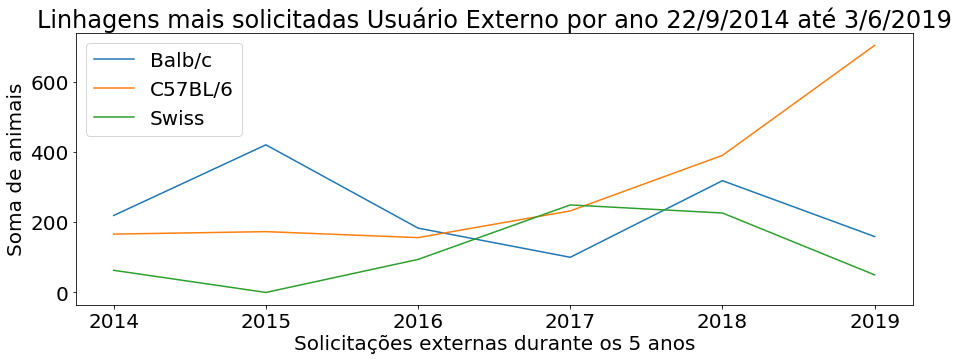

In [30]:
ling_mais_soli_ano = ['Balb/c','C57BL/6','Swiss']

plt.figure(figsize=(15, 5))
for l in ling_mais_soli_ano:
    pedido_df[pedido_df['ling'] == l]['num_ani'].resample('A').sum().plot()

#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#Editando o gráfico

plt.title(f'Linhagens mais solicitadas Usuário Externo por ano {inic.day}/{inic.month}/{inic.year} até {fim.day}/{fim.month}/{fim.year}')
plt.legend(ling_mais_soli_ano)
plt.xlabel('Solicitações externas durante os 5 anos')
plt.ylabel('Soma de animais')
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#Salvando o gráfico

plt.savefig(
    fname="../../resultados/solic_usuarioexterno_mais_ano_I.png", #pasta e nome do arquivo onde vai ser salvo
    bbox_inches='tight', #função que deixa o gráfico mais próxima da margem
    dpi=150, #numero de pixels da imagem?
    transparent=True #deixar o gráfico transparente
)

Gráfico solicitação de animais usuários externos linhagens mais pedidas mês a mês

In [31]:
# ling_mais_soli_mes = ['Balb/c', 'C57BL/6','Swiss']

# plt.figure(figsize=(15, 5))
# for c in ling_mais_soli_mes:
#     pedido_df[pedido_df['ling'] == c]['num_ani'].groupby([lambda x: x.month]).sum().plot()

# #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# #Editando o gráfico
# plt.title(f'Linhagens mais solicitadas Usuários Externos por mês {inic.day}/{inic.month}/{inic.year} até {fim.day}/{fim.month}/{fim.year}')
# plt.legend(ling_mais_soli_mes)
# plt.xlabel('Mês Nascimento')
# plt.ylabel('Soma de animais')

# #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# # #Salvando o gráfico

# # plt.savefig(
# #     fname="../resultados/13_pergunta_solic_usuarioexterno_mais_mes.png", #pasta e nome do arquivo onde vai ser salvo
# #     bbox_inches='tight', #função que deixa o gráfico mais próxima da margem
# #     dpi=150, #numero de pixels da imagem?
# #     transparent=True #deixar o gráfico transparente
# # )

Gráfico solicitação de animais usuários externos linhagens menos pedidas ano a ano

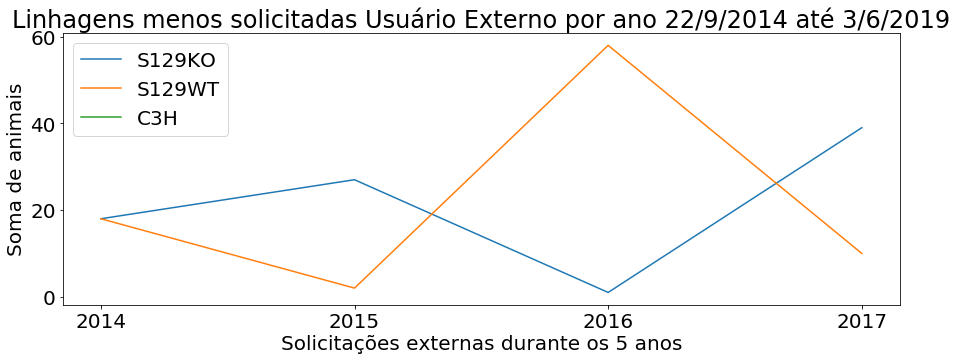

In [32]:
ling_menos_soli_ano = ['S129KO', 'S129WT', 'C3H' ]

plt.figure(figsize=(15, 5))
for l in ling_menos_soli_ano:
    pedido_df[pedido_df['ling'] == l]['num_ani'].resample('A').sum().plot()
    
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#Editando o gráfico

plt.title(f'Linhagens menos solicitadas Usuário Externo por ano {inic.day}/{inic.month}/{inic.year} até {fim.day}/{fim.month}/{fim.year}')
plt.legend(ling_menos_soli_ano)
plt.xlabel('Solicitações externas durante os 5 anos')
plt.ylabel('Soma de animais')

# #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#Salvando o gráfico
plt.savefig(
    fname="../../resultados/solic_usuarioexterno_menos_ano.png", #pasta e nome do arquivo onde vai ser salvo
    bbox_inches='tight', #função que deixa o gráfico mais próxima da margem
    dpi=150, #numero de pixels da imagem?
    transparent=True #deixar o gráfico transparente
)

Gráfico solicitação de animais usuários externos linhagens menos pedidas mês a mês

In [33]:
# ling_menos_soli_mes = ['S129KO', 'S129WT', 'C3H' ]

# plt.figure(figsize=(15, 5))
# for c in ling_menos_soli_mes:
#     pedido_df[pedido_df['ling'] == c]['num_ani'].groupby([lambda x: x.month]).sum().plot()

# #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# #Editando o gráfico

# plt.title(f'Linhagens menos solicitadas Usuários Externos por mês {inic.day}/{inic.month}/{inic.year} até {fim.day}/{fim.month}/{fim.year}')
# plt.legend(ling_menos_soli_mes)
# plt.xlabel('Mês Nascimento')
# plt.ylabel('Soma de animais')

# #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# #Salvando o gráfico

# plt.savefig(
#     fname="../resultados/13_pergunta_solic_usuarioexterno_menos_mes.png", #pasta e nome do arquivo onde vai ser salvo
#     bbox_inches='tight', #função que deixa o gráfico mais próxima da margem
#     dpi=150, #numero de pixels da imagem?
#     transparent=True #deixar o gráfico transparente
# )

Primeiros Resultados: As solicitações de Usuários externos é quase 3 vezes maior que internas, com um total de 4168 solicitações no período de 5 anos. Nas solicitações de animais como um todo, a linhagem com mais evento é a Balb/c (isogênica), em seguida a linhagem Swiss (heterogênica e em terceiro lugar a linhagem C57BL/6. Ao filtrar os dados apenas para pedidos externos, a linhagem mais solicitada é o C57BL/6, em segundo lugar a linhagem Balb/c e em terceiro a linhagem Swiss.

Resultado por período anual (linhagens mais pedidas):
C57BL/6 - Solicitação desde 2014 se manteve constante entre os anos de 2015 a 2017, sendo sua produção superior nos anos de 2018 e 2019.

Balb/c - teve um pico maior de solicitação em 2015 e 2018 e teve uma menor produção no ano de 2016 e 2017.

Swiss - Entre 2015, 2016 e 2019 foi o menor período de solicitação e maior produção entre 2017 e 2018.

Resultado por períodos mensal(linhagens mais pedidas):
C57BL/6 - Solicitação constante entre todos os mêses, exceto mês de Maio que demonstra menor solicitação.

Balb/c - Menor solicitação entre os mêses de Abril, Julho e Agosto.

Swiss - Solicitação baixa em comparação as outras linhagens e Menor solicitação entre os mêses de Abril até Junho.

Resultado por período anual (linhagens menos pedidas):
S129 WT - Sem solicitações no ano de 2015, sendo solicitada no ano de 2016 e baixa em 2017 - Não há registros de solicitações pra 2018 e 2019.

S129KO - Com solicitação no ano de 2015 e 2017 sem solicitação em 2016. - Não há registros de solicitações pra 2018 e 2019.

C3H - Apenas uma solicitação externa de 4 camundongos 2019(confirmar) (não apresentado no gráfico).

Resultado por período mensal (linhagens menos pedidas):
S129 WT - Sem solicitação entre os mêses de Janeiro a Abril, com maior solicitação de Junho a Outubro.

S129 KO - Maior solicitação entre Outubro e Dezembro, nos demais meses se manteve constante.

C3H - Sem solicitações.